## ABOUT THE PROJECT

* This analysis was conducted by me, Yashasvi Bhati, as a Data Intern candidate, as part of a small project.
* The dataset used for this analysis is sourced from the Connecticut Open Data Portal.

Data file: https://raw.githubusercontent.com/bhatiyashasvi/Surgeons-CT/refs/heads/main/Physician_Surgeon_Licenses.csv



## THE APPROACH
*   Focused primarily on the state of Conneticut and on Hartford and surroundings
*   Futher filtered down to only the active licenses in the dataset which was recently updated in 2024
*   Dropped columns & their reasons :
  * **DBA, BusinessName** : uncertain of it's meaning
  * **CredentialType, CredentialSubCategory, Status, Credential, Active, State** : single value across all rows
  * **IssueDate, EffectiveDate, ExpirationDate** : irrelevant as we have already filtered our approach from 'active' licenses
  * **Name** : treating CredentialId as the unique identifier for each row and thus also using it as the index



## Importing libraries




In [ ]:
from datetime import datetime
print(f'Run time: {datetime.now().strftime("%D %T")}')

Run time: 12/05/24 20:34:17


In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopandas as gpd
from geopy.geocoders import Nominatim
# incase needed
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition

## Examining Data

In [ ]:
# reading the data
doc = pd.read_csv('https://raw.githubusercontent.com/bhatiyashasvi/Surgeons-CT/refs/heads/main/Physician_Surgeon_Licenses.csv', sep=',', index_col='CredentialId')
pd.set_option('display.max_columns', None)

In [ ]:
# looking at the dataframe shape
doc.shape

(11948, 19)

In [ ]:
# displaying the dataframe
doc.sample(2)

,Name,Type,BusinessName,DBA,FullCredentialCode,CredentialType,CredentialNumber,CredentialSubCategory,Credential,Status,StatusReason,Active,IssueDate,EffectiveDate,ExpirationDate,City,State,Zip,RecordRefreshedOn
CredentialId,,,,,,,,,,,,,,,,,,,
547012,BENJAMIN TSANG MD,INDIVIDUAL,NaN,NaN,1.028174,1,28174,NaN,Physician/Surgeon,ACTIVE,CURRENT,1,06/12/1987,01/01/2025,12/31/2025,STAMFORD,CT,069012333,10/30/2024
1335463,SI HYUNG WOO,INDIVIDUAL,NaN,NaN,1.055193,1,55193,NaN,Physician/Surgeon,ACTIVE,CURRENT,1,04/25/2016,05/01/2024,04/30/2025,Farmington,CT,06030,04/01/2024


## Exploratory Data Analysis on Raw Data

In [ ]:
# initialising columns to drop
cols_to_drop = [
    'Name', 'BusinessName', 'DBA', 'FullCredentialCode', 'CredentialType', 'CredentialNumber', 'CredentialSubCategory',
    'Credential','Status', 'Active', 'IssueDate', 'EffectiveDate', 'ExpirationDate', 'State', 'RecordRefreshedOn']

# making a copy of raw data for future references
# updated_doc = doc.copy()

# droppping the columns
updated_doc = doc.drop(columns=cols_to_drop)

In [ ]:
# displaying the updated dataframe
updated_doc.head(5)

,Type,StatusReason,City,Zip
CredentialId,,,,
1000575,INDIVIDUAL,CURRENT,Ridgefield,06877
1115938,INDIVIDUAL,CURRENT,South Windsor,06074
1174317,INDIVIDUAL,CURRENT,Fairfield,06825
1195955,INDIVIDUAL,CURRENT,New Haven,06511
1277627,INDIVIDUAL,CURRENT,WEST HARTFORD,06110


In [ ]:
# examining the ExpirationDate column to get an idea about the recency of our data
# converting the column to datetime format
doc['ExpirationDate'] = pd.to_datetime(doc['ExpirationDate'], errors='coerce')

# eliminating columns that failed to convert
doc = doc.dropna(subset=['ExpirationDate'])

# finding the range
expiry_date_min = doc['ExpirationDate'].min()
expiry_date_max = doc['ExpirationDate'].max()

print(f"Earliest expiry date: {expiry_date_min}")
print(f"Farthest expiry date: {expiry_date_max}")
print(f"Date range (days): {(expiry_date_max - expiry_date_min).days}")

Earliest expiry date: 2023-11-30 00:00:00
Farthest expiry date: 2027-03-31 00:00:00
Date range (days): 1217


In [ ]:
# examining the RecordRefreshedOn column to get an idea about the recency of our data
# converting the column to datetime format
doc['RecordRefreshedOn'] = pd.to_datetime(doc['RecordRefreshedOn'], errors='coerce')

# eliminating columns that failed to convert
doc = doc.dropna(subset=['RecordRefreshedOn'])

# finding the range
refresh_date_min = doc['RecordRefreshedOn'].min()
refresh_date_max = doc['RecordRefreshedOn'].max()

print(f"Earliest refresh date: {refresh_date_min}")
print(f"Latest refresh date: {refresh_date_max}")
print(f"Date range (days): {(refresh_date_max - refresh_date_min).days}")


Earliest refresh date: 2022-11-29 00:00:00
Latest refresh date: 2024-12-02 00:00:00
Date range (days): 734


In [ ]:
# looking at the Status column
doc['Status'].value_counts()

,count
Status,
ACTIVE,11948


The findings from earliest and latest dates for ExpirationDate and RecordRefreshedOn conveys that there is a possibilty of this dataset not being up-to-date even though Status is active.

This is also something that can be worked as a part of in-depth analysis by:
*   checking if the rows overlap from ExpirationDate & RecordRefreshedOn
*   grouping these rows by City to get an insight about Hartford & neighbouring areas



## Exploratory Data Analysis on Updated Data

In [ ]:
# displaying the updated dataframe
updated_doc.head(5)

,Type,StatusReason,City,Zip
CredentialId,,,,
1000575,INDIVIDUAL,CURRENT,Ridgefield,06877
1115938,INDIVIDUAL,CURRENT,South Windsor,06074
1174317,INDIVIDUAL,CURRENT,Fairfield,06825
1195955,INDIVIDUAL,CURRENT,New Haven,06511
1277627,INDIVIDUAL,CURRENT,WEST HARTFORD,06110


#### Duplicated Values

In [ ]:
# checking for any duplicates
updated_doc.duplicated().sum()

7859

In [ ]:
doc.duplicated().sum()

0

Notice that the initial dataframe 'doc' has 0 duplicates the 'updated_doc' has plenty! This is a result of large number of columns being dropped and no unique identifier in the dataset.

I would still like to go ahead and keep the duplicates as they will be useful to identify the dense areas.

#### Missing Values

In [ ]:
# checking for any missing values
updated_doc.isnull().sum()

,0
Type,0
StatusReason,0
City,1
Zip,0


In [ ]:
# dropping the missing value since it is only a single row
updated_doc = updated_doc.dropna()
updated_doc.isnull().sum()

,0
Type,0
StatusReason,0
City,0
Zip,0


## Visualizations

In [ ]:
type_counts = updated_doc['Type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']  # Rename columns for clarity

# Create an interactive bar plot
fig = px.bar(
    type_counts,
    x='Type',
    y='Count',
    text='Count',
    title='Bar Plot of License Type',
    labels={'Type': 'Type', 'Count': 'Count'},
    template='plotly_dark'
)

# Add value labels on the bars
fig.update_traces(textposition='outside')

# Show the plot
fig.show()

In [ ]:
status_reason_counts = updated_doc['StatusReason'].value_counts().reset_index()
status_reason_counts.columns = ['StatusReason', 'Count']

# Create an interactive bar plot
fig = px.bar(
    status_reason_counts,
    x='StatusReason',
    y='Count',
    text='Count',
    title='Bar Plot of StatusReason',
    labels={'StatusReason': 'Status Reason', 'Count': 'Count'},
    template='plotly_dark'
)

# Add value labels on the bars
fig.update_traces(textposition='outside')

# Show the plot
fig.show()

## GeoData Prep

Data file: https://gist.githubusercontent.com/steinbring/e5417af6d1bb95742555866c84e3f91d/raw/186b532887c9738687860aeae5de7a7b2a0ed233/cityStateToLatLong.csv

In [ ]:
# readig the geodata file
geo_data = pd.read_csv('https://gist.githubusercontent.com/steinbring/e5417af6d1bb95742555866c84e3f91d/raw/186b532887c9738687860aeae5de7a7b2a0ed233/cityStateToLatLong.csv', sep=',')

In [ ]:
pd.set_option('display.max_columns', None)
geo_data.head(2)

,state,city,latitude,longitude
0,AL,Abanda CDP,33.091627,-85.527029
1,AL,Abbeville city,31.564724,-85.259123


In [ ]:
geo_data.shape

(31909, 4)

In [ ]:
# values where state = CT
ct_data = geo_data[geo_data['state'] == 'CT']
ct_data.columns = ct_data.columns.str.strip()

In [ ]:
ct_data.shape

(215, 4)

In [ ]:
ct_data.head(2)

,state,city,latitude,longitude
4133,CT,Ansonia city,41.344249,-73.069825
4134,CT,Ball Pond CDP,41.461651,-73.526846


In [ ]:
updated_doc.head(2)

,Type,StatusReason,City,Zip
CredentialId,,,,
1000575,INDIVIDUAL,CURRENT,Ridgefield,06877
1115938,INDIVIDUAL,CURRENT,South Windsor,06074


In [ ]:
ct_data.columns # notice that there is extra spaces in column name

Index(['state', 'city', 'latitude', 'longitude'], dtype='object')

In [ ]:
# stripping the extra space and renaming columns
ct_data.columns = ct_data.columns.str.strip()

ct_data.rename(columns={
    'latitude': 'Latitude',
    'longitude': 'Longitude'
}, inplace=True)

# dropping any rows with missing values
ct_data = ct_data.dropna(subset=['Latitude', 'Longitude'])

<ipython-input-26-94d69d197e92>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



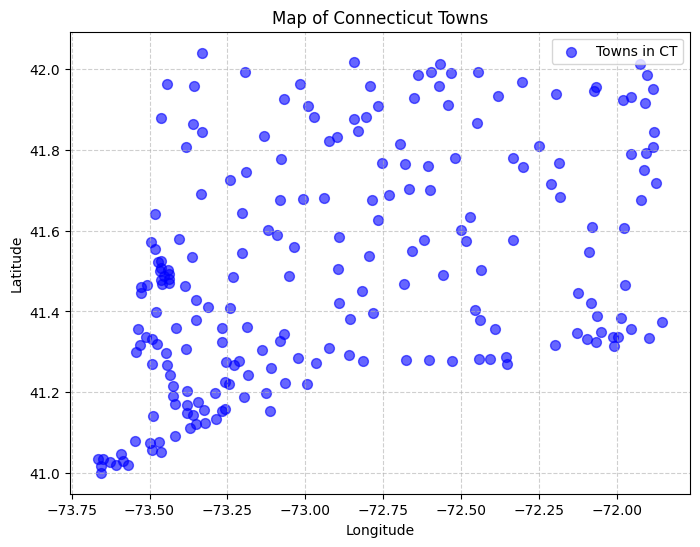

In [ ]:
# plotting the data
plt.figure(figsize=(8, 6))

plt.scatter(ct_data['Longitude'], ct_data['Latitude'],
            color='blue', alpha=0.6, s=50, label='Towns in CT')

# setting labels, grid and legend
plt.title('Map of Connecticut Towns', fontsize=12)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Cleaning the datasets for merging

In [ ]:
ct_data.head(2)

,state,city,Latitude,Longitude
4133,CT,Ansonia city,41.344249,-73.069825
4134,CT,Ball Pond CDP,41.461651,-73.526846


In [ ]:
updated_doc.head(2)

,Type,StatusReason,City,Zip
CredentialId,,,,
1000575,INDIVIDUAL,CURRENT,Ridgefield,06877
1115938,INDIVIDUAL,CURRENT,South Windsor,06074


In [ ]:
# ideal to merge the datasets on column 'City'
# renaming the column city to make them identical
ct_data.rename(columns={'city': 'City'}, inplace=True)

In [ ]:
# defining a function to clean the city column
def clean_city_column(df):
    df['City'] = (df['City']
                  .str.strip()
                  .str.upper()
                  .str.replace(r'\s+city$', '', regex=True)
                  .str.replace(r'\s+cdp$', '', regex=True)
                  .str.replace(r'\s+', ' ', regex=True)
                  )
    return df

In [ ]:
# applying the function
ct_data = clean_city_column(ct_data)
updated_doc = clean_city_column(updated_doc)

In [ ]:
# mergeing the datasets
merged_data = pd.merge(updated_doc, ct_data, on='City', how='inner')

In [ ]:
merged_data.isnull().sum()

,0
Type,0
StatusReason,0
City,0
Zip,0
state,0
Latitude,0
Longitude,0


In [ ]:
# exporting the file to Tableau for any dashboard
'''
merged_data.to_csv('/content/merged_data.csv', index=False)

from google.colab import files
files.download('/content/merged_data.csv')
'''

"\nmerged_data.to_csv('/content/merged_data.csv', index=False)\n\nfrom google.colab import files\nfiles.download('/content/merged_data.csv')\n"

## WorkingSpace - Trial & Error


*   these codes are for trial, reference and brainstorming for possible visualizations.



In [ ]:
'''
#ct_data = ct_data.dropna(subset=['longitude', 'latitude'])

plt.figure(figsize=(10, 8))

plt.scatter(ct_data['longitude'], ct_data['latitude'],
            color='blue', alpha=0.6, s=50, label='Towns in CT')

# Add titles and labels
plt.title('Map of Connecticut Towns', fontsize=16)
plt.xlabel('longitude', fontsize=12)
plt.ylabel('latitude', fontsize=12)

# adding grids and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(14, 12))

plt.scatter(ct_data['longitude'], ct_data['latitude'],
            color='blue', alpha=0.6, s=50, label='Towns in CT')

# Add title and labels
plt.title('Map of Connecticut Towns', fontsize=16)
plt.xlabel('longitude', fontsize=12)
plt.ylabel('latitude', fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.show()
'''

"\n#ct_data = ct_data.dropna(subset=['longitude', 'latitude'])\n\nplt.figure(figsize=(10, 8))\n \nplt.scatter(ct_data['longitude'], ct_data['latitude'], \n            color='blue', alpha=0.6, s=50, label='Towns in CT')\n\n# Add titles and labels\nplt.title('Map of Connecticut Towns', fontsize=16)\nplt.xlabel('longitude', fontsize=12)\nplt.ylabel('latitude', fontsize=12)\n\n# adding grids and legend \nplt.grid(True, linestyle='--', alpha=0.6)\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(14, 12))\n\nplt.scatter(ct_data['longitude'], ct_data['latitude'], \n            color='blue', alpha=0.6, s=50, label='Towns in CT')\n\n# Add title and labels\nplt.title('Map of Connecticut Towns', fontsize=16)\nplt.xlabel('longitude', fontsize=12)\nplt.ylabel('latitude', fontsize=12)\n\n# Add grid and legend\nplt.grid(True, linestyle='--', alpha=0.6)\nplt.legend()\n\n# Show the plot\nplt.show()\n"

In [ ]:
'''
# reading the shape file'
ct_shape = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_50_place.zip')
'''

"\n# reading the shape file'\nct_shape = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_50_place.zip')\n"